In [3]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import io
from ase.optimize import BFGS, LBFGS, FIRE, LBFGSLineSearch
from ase.visualize import view
from ase.io import Trajectory
from ase import Atoms
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


macemp0 = mace_mp(dispersion=True, default_dtype="float64", model="medium")
macemp = mace_mp(dispersion=True, default_dtype="float64")

/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Using Materials Project MACE for MACECalculator with /Users/joehart/.cache/mace/macempa0mediummodel
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [6]:
graphene_atoms = io.read("../structures/graphene_atoms.xyz")
mxene_relaxed_mace = io.read("../structures/mxene_relaxed_mace.xyz")
mxene_relaxed_omat = io.read("../structures/mxene_relaxed_omat.xyz")

mxene_unit_mace = io.read("../structures/relax_mxene_unit_mace.xyz")
mxene_unit_omat = io.read("../structures/relax_mxene_unit_omat.xyz")

### MXene thickness

In [3]:
def calculate_thickness(atoms):
    top_O_z = [atom.position[2] for atom in atoms if atom.tag == 3]
    bottom_O_z = [atom.position[2] for atom in atoms if atom.tag == 1]
    
    thickness = np.mean(top_O_z) - np.mean(bottom_O_z)
    return thickness

In [4]:
calculate_thickness(mxene_relaxed_mace)

4.463190900000001

In [5]:
calculate_thickness(mxene_relaxed_omat)

4.46016048

### Bond distances in MXene

In [16]:
top_o = [atom for atom in mxene_relaxed_mace if atom.tag == 3]
bottom_o = [atom for atom in mxene_relaxed_mace if atom.tag == 1]
mxene_c = [atom for atom in mxene_relaxed_mace if atom.symbol == "C"]
bottom_ti = [atom for atom in mxene_relaxed_mace if atom.symbol == "Ti" and atom.position[2] < np.mean([atom.position[2] for atom in mxene_relaxed_mace if atom.symbol == "C"])]
top_ti = [atom for atom in mxene_relaxed_mace if atom.symbol == "Ti" and atom.position[2] > np.mean([atom.position[2] for atom in mxene_relaxed_mace if atom.symbol == "C"])]

In [286]:
from ase.neighborlist import neighbor_list

cutoffs = {"Ti-O": 2.5, "Ti-C": 2.5, "Ti-Ti": 3.1}

def compute_bonded_distances(atoms, sym1, sym2, cutoff):
    """Finds and computes bonded distances between sym1 and sym2 atoms."""
    indices1 = [atom.index for atom in atoms if atom.symbol == sym1]
    indices2 = [atom.index for atom in atoms if atom.symbol == sym2]

    i_list, j_list, distances = neighbor_list("ijd", atoms, cutoff)

    bonded_distances = [
        d for i, j, d in zip(i_list, j_list, distances)
        if (i in indices1 and j in indices2) or (i in indices2 and j in indices1)
    ]
    return bonded_distances

ti_o_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "O", cutoffs["Ti-O"])
ti_c_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "C", cutoffs["Ti-C"])
ti_ti_bonds = compute_bonded_distances(mxene_relaxed_mace, "Ti", "Ti", cutoffs["Ti-Ti"])


print(f"Bonded Ti-O Distances:{np.mean(ti_o_bonds)}, {np.std(ti_o_bonds)}")
print(f"Bonded Ti-C Distances:{np.mean(ti_c_bonds)}, {np.std(ti_c_bonds)}")
print(f"Bonded Ti-Ti Distances:{np.mean(ti_ti_bonds)}, {np.std(ti_ti_bonds)}")

Bonded Ti-O Distances:1.9764461583387696, 2.494785538872408e-09
Bonded Ti-C Distances:2.186571924739105, 2.543624509981871e-09
Bonded Ti-Ti Distances:3.03, 2.891379023583233e-09


### Visualisation of MXene

In [ ]:
from scipy.spatial.distance import pdist, squareform
from ase.visualize.plot import plot_atoms

def plot_mxene(frame, filepath=None):
    cell = frame.cell
    a1, a2 = cell[0][:2], cell[1][:2]

    # Supercell outline
    parallelogram = np.array([
        np.array([0, 0]),
        a1,
        a1 + a2,
        a2,
        np.array([0, 0])
    ])
    
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)

    # Unit cell outline
    unit_a1 = a1 / 4
    unit_a2 = a2 / 4
    unit_parallelogram = np.array([
        np.array([0, 0]),
        unit_a1,
        unit_a1 + unit_a2,
        unit_a2,
        np.array([0, 0])
    ])
    
    plt.plot(unit_parallelogram[:, 0], unit_parallelogram[:, 1], 'b--', linewidth=1.5)

    mxene_atoms = Atoms([atom for atom in frame if atom.tag in [0, 1, 2, 3] and atom.symbol != 'Na'])
    positions = mxene_atoms.get_positions()[:, :2]
    num_atoms = len(positions)
    
    bond_cutoff = 2.5
    dist_matrix = squareform(pdist(positions))

    tags = mxene_atoms.get_tags()
    color_map = {0: "lightgrey", 1: "red", 2: "grey", 3: "red"}  # Ti = lightgrey, O = red, C = grey
    atom_colors = [color_map[tag] for tag in tags]
    
    labels_added = {'Ti': False, 'C': False, 'O': False}
    legend_order = {'Ti': 0, 'C': 1, 'O': 2}

    for i, pos in enumerate(positions):
        if tags[i] == 0:
            label = "Ti" if not labels_added['Ti'] else None
            labels_added['Ti'] = True
            size = 500
        elif tags[i] == 3:
            label = "O" if not labels_added['O'] else None
            labels_added['O'] = True
            size = 150
        elif tags[i] != 1:
            label = "C" if not labels_added['C'] else None
            labels_added['C'] = True
            size = 200
        else:
            continue

        plt.scatter(pos[0], pos[1], s=size, c=atom_colors[i], edgecolors="black", label=label, zorder=2)

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            if dist_matrix[i, j] < bond_cutoff:
                if tags[i] != 1:
                    plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)

    plt.axis("equal")
    plt.axis("off")

    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_order.get(x[1], float('inf')))
    handles, labels = zip(*sorted_handles_labels)

    plt.legend(handles, labels, handletextpad=1, labelspacing=1, borderpad=0.8)
    
    if filepath:
        plt.savefig(f"../figures/{filepath}")
    plt.show()


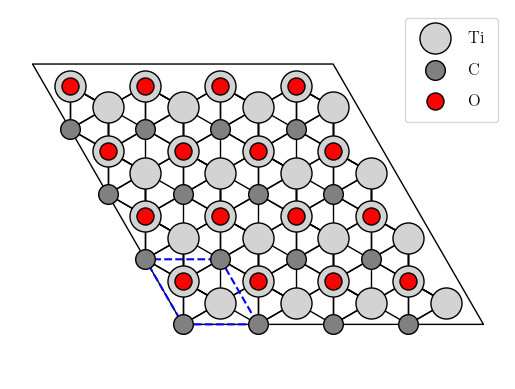

In [12]:
plot_mxene(mxene_relaxed_omat, filepath = 'mxene_top_view.pdf')

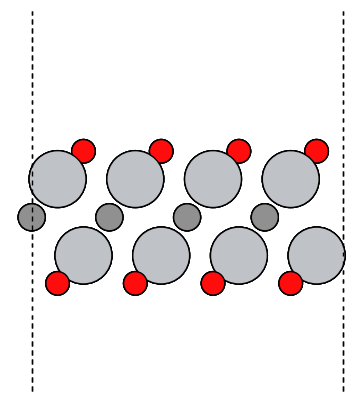

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))


plot_atoms(mxene_relaxed_omat, ax, radii=0.6, rotation=('90x, 30y, 0z'))


plt.axis("off")
#plt.xlim(7, 20)
plt.ylim(25,38)
plt.savefig("../figures/mxene.pdf")
plt.show()

### Interlayer spacing diagrams

In [210]:
m_g_relaxed = io.read("structures/m_g_relaxed_omat.xyz")
m_go_relaxed = io.read("structures/m_go_relaxed_omat.xyz")
m_goh_relaxed = io.read("structures/m_goh_relaxed_omat.xyz")

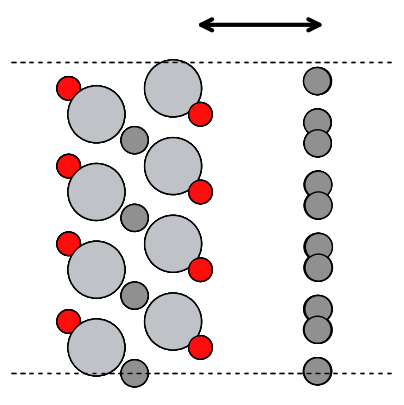

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_atoms(m_g_relaxed, ax, radii=0.6, rotation=('90x, 30y, 90z'))


plt.annotate("", xy=(13.2, 12.5), xytext=(17.7, 12.5),
            arrowprops=dict(arrowstyle="<->", lw=3, color="black", mutation_scale=20))


plt.axis("off")
plt.xlim(7, 20)
plt.ylim(0,13)
plt.savefig("figures/interlayer_spacing_mg_diagram.pdf")
plt.show()

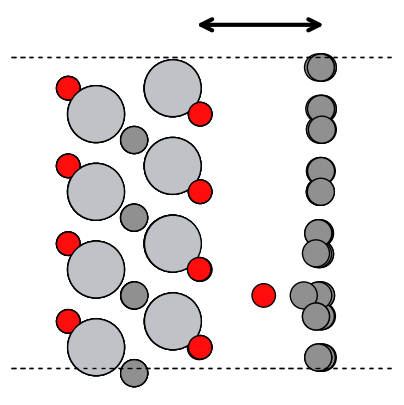

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))


plot_atoms(m_go_relaxed, ax, radii=0.6, rotation=('90x, 30y, 90z'))

plt.annotate("", xy=(13.2, 12.5), xytext=(17.7, 12.5),
            arrowprops=dict(arrowstyle="<->", lw=3, color="black", mutation_scale=20))

plt.axis("off")
plt.xlim(7, 20)
plt.ylim(0,13)
plt.savefig("figures/interlayer_spacing_mgo_diagram.pdf")
plt.show()

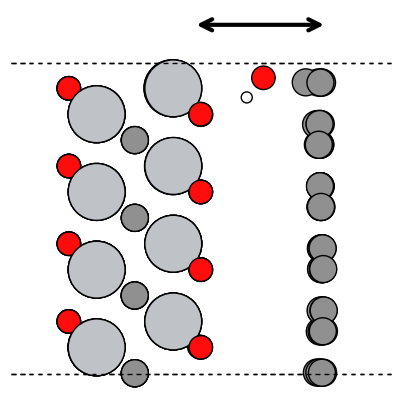

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))


plot_atoms(m_goh_relaxed, ax, radii=0.6, rotation=('90x, 30y, 90z'))

plt.annotate("", xy=(13.2, 12.5), xytext=(17.7, 12.5),
            arrowprops=dict(arrowstyle="<->", lw=3, color="black", mutation_scale=20))

plt.axis("off")
plt.xlim(7, 20)
plt.ylim(0,13)
plt.savefig("figures/interlayer_spacing_mgoh_diagram.pdf")
plt.show()